In [16]:
import numpy as np

N = 10000 # number of samples to generate; the actual size may be smaller because of the prior
D = 16 # number of dims
a = 1.
b = 0.5
lower = np.full(D, -30.) # lower bound of the prior for x_1, ...
upper = np.full(D, 30.) # upper bound of the prior for x_1, ...
lower[0] = -4 # lower bound of the prior for x_0
upper[0] = 8 # upper bound of the prior for x_0
bound = np.array((lower, upper)).T
diff = bound[:, 1] - bound[:, 0]
const = np.sum(np.log(diff)) # normalization of the flat prior

def logp(x):
    n = x.shape[-1]
    _a = -0.5 * x[..., 0]**2 / a**2
    _b = -0.5 * np.sum(x[..., 1:]**2, axis=-1) * np.exp(-2 * b * x[..., 0])
    _c = (-0.5 * np.log(2 * np.pi * a**2) - 
          0.5 * (n - 1) * np.log(2 * np.pi) - (n - 1) * b * x[..., 0])
    return _a + _b + _c - const

def grad(x):
    n = x.shape[-1]
    foo = -x / np.insert(np.full((*x.shape[:-1], n - 1), 
                                 np.exp(2 * b * x[..., 0])), 0, a**2, axis=-1)
    foo[0] += b * np.sum(x[..., 1:]**2, axis=-1) * np.exp(-2 * b * x[..., 0])
    foo[0] -= (n - 1) * b
    return foo

def _in_bound(x, bound):
    xt = np.atleast_2d(x).T
    return np.product([np.where(xi>bound[i,0], True, False) * 
                       np.where(xi<bound[i,1], True, False) for i, xi in 
                       enumerate(xt)], axis=0).astype(bool)

In [17]:
np.random.seed(0)
x = np.random.randn(N, D)
x[:, 0] *= a
x[:, 1:] *= np.exp(b * x[:, :1])
x = x[_in_bound(x, bound)]
logpx = logp(x)[:,np.newaxis]
np.save('funnel_{}.npy'.format(x.shape[0]), np.hstack((x,logpx)))

Removed no burn in


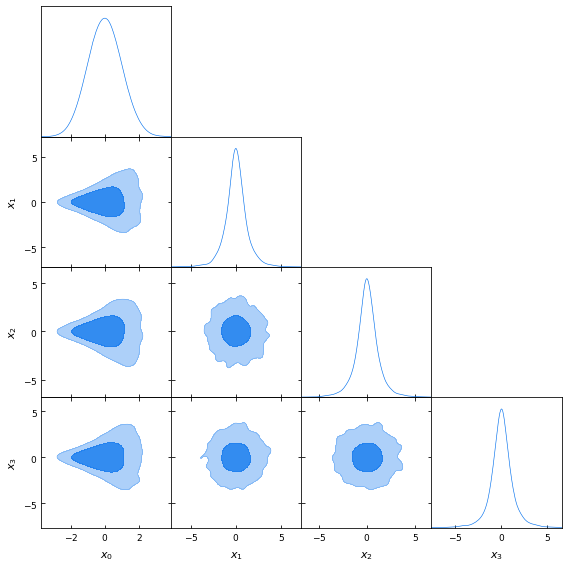

In [18]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

names = ["x_%s"%i for i in range(4)]
labels = ["x_%s"%i for i in range(4)]
s = MCSamples(samples=x[:, :4], names=names, labels=labels)
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})
plt.show()